# ⚠️ DEPRECATED - Use marimo version instead

**This Jupyter notebook is deprecated.** Please use [`weight_analysis_marimo.py`](weight_analysis_marimo.py) instead.

The marimo version offers:
- ✅ Better reactivity (cells auto-update when dependencies change)
- ✅ Cleaner git diffs (stored as pure Python)
- ✅ More modern interactive experience
- ✅ No cell execution order issues

To run the marimo version:
```bash
marimo edit weight_analysis_marimo.py --watch
```


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("ggplot")
import seaborn as sns
import matplotlib as mpl
import arrow
from matplotlib import animation
from IPython.display import HTML
from datetime import timedelta
import altair as alt


%matplotlib inline

In [23]:
## Getting and preparing the input file
# Export data using HealthAutoExport
# *********************************************************************************************************************
# NOTE: There is a trailing comma on the csv on the export file --> SO: You need to add a junk column in the header
# *********************************************************************************************************************
# exported_and_trandformed_csv_file = "data/metrics-2024-03-08.csv"
exported_and_trandformed_csv_file = "data/metrics-2024-09-01.csv"

In [24]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################
df = pd.read_csv(exported_and_trandformed_csv_file, sep=",")
# idx_weight_kg = "Weight (kg)"
idx_weight, min_weight = "Weight/Body Mass (lb)", 140
# idx_weight, min_weight = "Body Fat Percentage (%)", 20
# Weight (lb)"
# make dateColumn a datetime.
idx_date = "Date"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])

# Drop any invalid dates
# df = df.dropna(subset=[idx_date])
df = df.sort_index()
# print number of rows

# Create Time Period Groups
idx_month_year = "month_year"
df[idx_month_year] = df.index.to_series().apply(lambda t: arrow.get(t).format("MMM-YY"))

idx_week_year = "week_year"
df[idx_week_year] = df.index.to_series().apply(lambda t: f"{t.week}-{t.year - 2000}")

idx_quarter_year = "quarter_year"
df[idx_quarter_year] = df.index.to_series().apply(
    lambda t: arrow.get(t).ceil("quarter").format("MMM-YY")
)

#########################
# Clean data
###########################


# Remove 0 weight values.
df = df.replace(0, np.nan)

# remove data before 2010
df = df[df.index > "2010-01-01"]


# (not sure why mypy can't handle this)
# KG to lbs
# df[idx_weight] = df[idx_weight_kg] * 2.2
# df[idx_weight] = df[idx_weight_kg]

# Throw away any weights less then minimum as bad data
df = df[df[idx_weight] > min_weight]

dfW = df[idx_weight]


# Remove any rows with 0 values


# Helpful time aliases
df_alltime = df
display(df)

,Date,Body Fat Percentage (%),Heart Rate Variability (ms),Lean Body Mass (lb),Mindful Minutes (min),Resting Heart Rate (bpm),Sleep Analysis [Asleep] (hr),Sleep Analysis [In Bed] (hr),Sleep Analysis [Core] (hr),Sleep Analysis [Deep] (hr),Sleep Analysis [REM] (hr),Sleep Analysis [Awake] (hr),VO2 Max (ml/(kg·min)),Weight/Body Mass (lb),Junk,month_year,week_year,quarter_year
Date,,,,,,,,,,,,,,,,,,
2015-09-26,2015-09-26,NaN,NaN,NaN,NaN,NaN,8.750278,NaN,NaN,NaN,NaN,NaN,NaN,164.0,NaN,Sep-15,39-15,Sep-15
2015-09-28,2015-09-28,NaN,NaN,NaN,NaN,NaN,3.514167,NaN,NaN,NaN,NaN,NaN,NaN,164.0,NaN,Sep-15,40-15,Sep-15
2015-09-29,2015-09-29,NaN,NaN,NaN,NaN,NaN,6.821944,NaN,NaN,NaN,NaN,NaN,NaN,161.0,NaN,Sep-15,40-15,Sep-15
2015-09-30,2015-09-30,NaN,NaN,NaN,NaN,NaN,6.983333,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,Sep-15,40-15,Sep-15
2015-10-05,2015-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,NaN,Oct-15,41-15,Dec-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-13,2024-08-13,22.7,42.72,137.8,NaN,57.0,8.150000,8.633333,6.083333,0.508333,2.116667,1.000000,NaN,178.2,NaN,Aug-24,33-24,Sep-24
2024-08-16,2024-08-16,22.8,50.93,137.6,NaN,59.0,10.250000,11.016667,14.158333,1.750000,4.141667,1.775000,NaN,178.0,NaN,Aug-24,33-24,Sep-24
2024-08-17,2024-08-17,22.7,41.44,137.4,NaN,66.0,7.050000,8.133988,8.625000,1.416667,2.900000,2.266667,NaN,177.6,NaN,Aug-24,33-24,Sep-24


In [32]:
def box_plot_weight_mpl(df, x, title=""):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width.
    height_in_inches = 8
    mpl.rc("figure", figsize=(4 * height_in_inches, height_in_inches))

    # Create a custom color palette
    palette = sns.color_palette("husl", len(df[x].unique()))
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right")

    # Create the boxplot with the custom palette
    ax = sns.boxplot(x=x, y=idx_weight, data=df, palette=palette, hue=x, legend=False)

    # Set title and labels with improved styling
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Weight (lbs)", fontsize=12)

    # Improve the overall style
    sns.set_style("whitegrid")
    plt.tight_layout()

    # Show the plot
    plt.show()


def box_plot_weight_vegas(df, x, title, domain=(150, 250)):
    height_in_inches = 4 * 60  # todo figure out how to get this by calculation
    y_min = min(df[idx_weight]) - 10
    y_max = max(df[idx_weight]) + 10
    domain = (y_min, y_max)
    display(domain)
    c = (
        alt.Chart(df)
        .mark_boxplot()
        .encode(
            y=alt.Y(idx_weight, scale=alt.Scale(domain=domain, clamp=True)),
            x=alt.X(x, type="temporal", sort="ascending"),
        )
        .properties(width=4 * height_in_inches, height=height_in_inches, title=title)
        .interactive()
    )
    display(c)

Timestamp('2022-08-24 00:00:00')

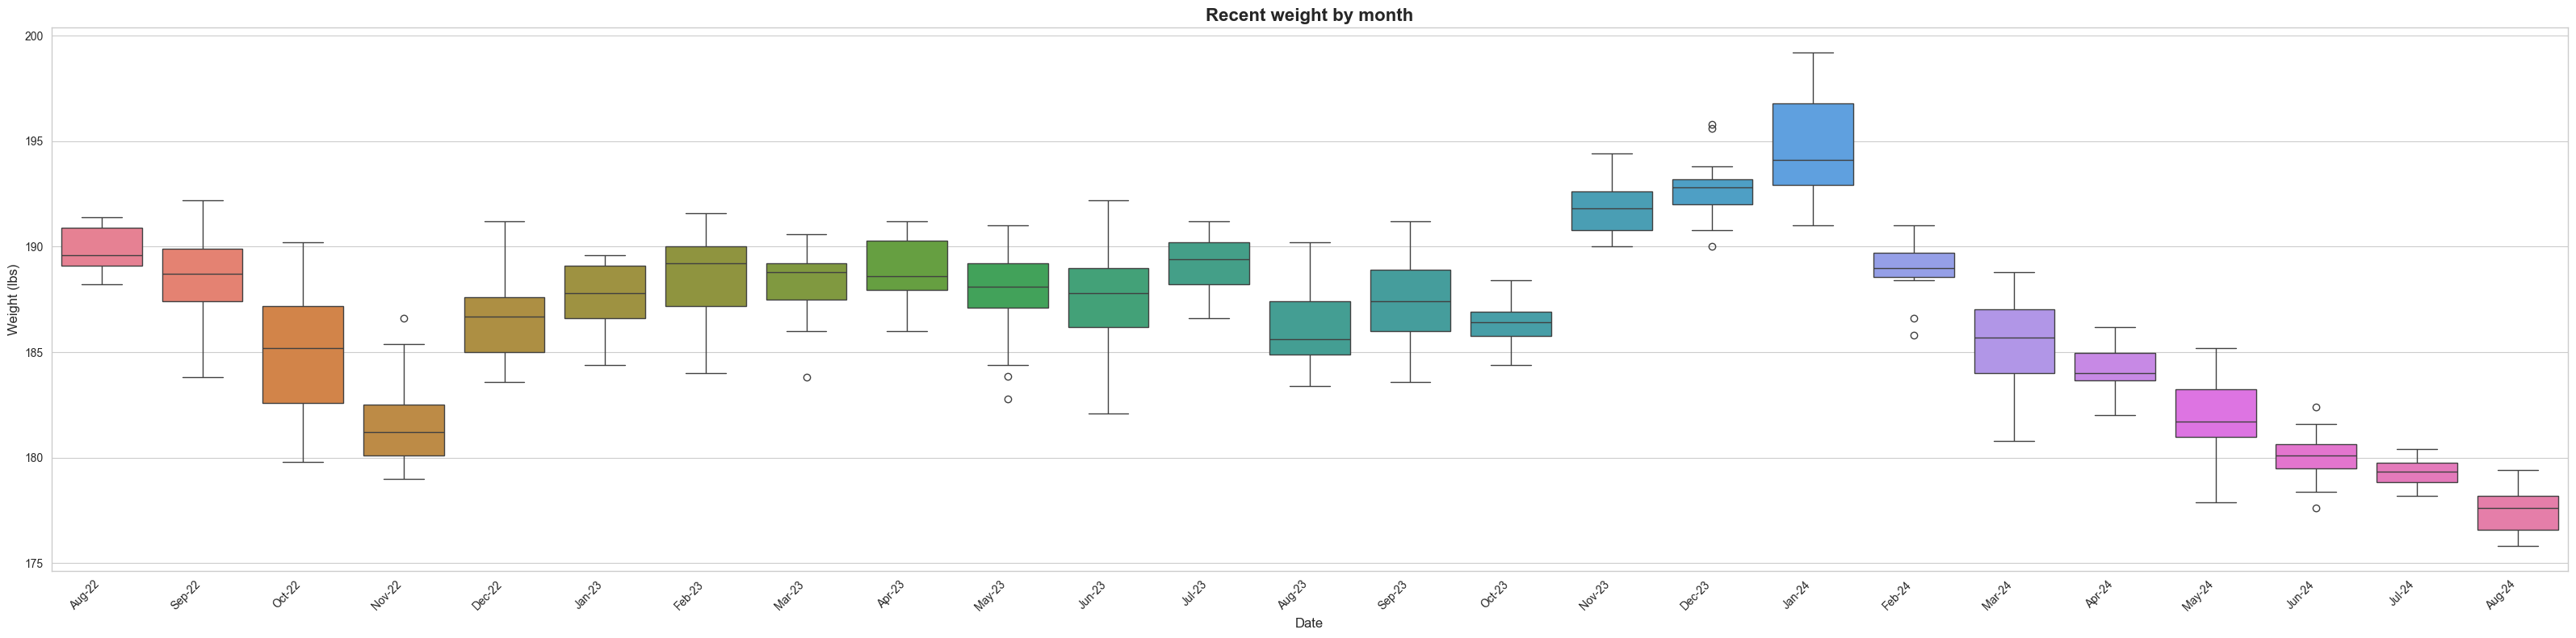

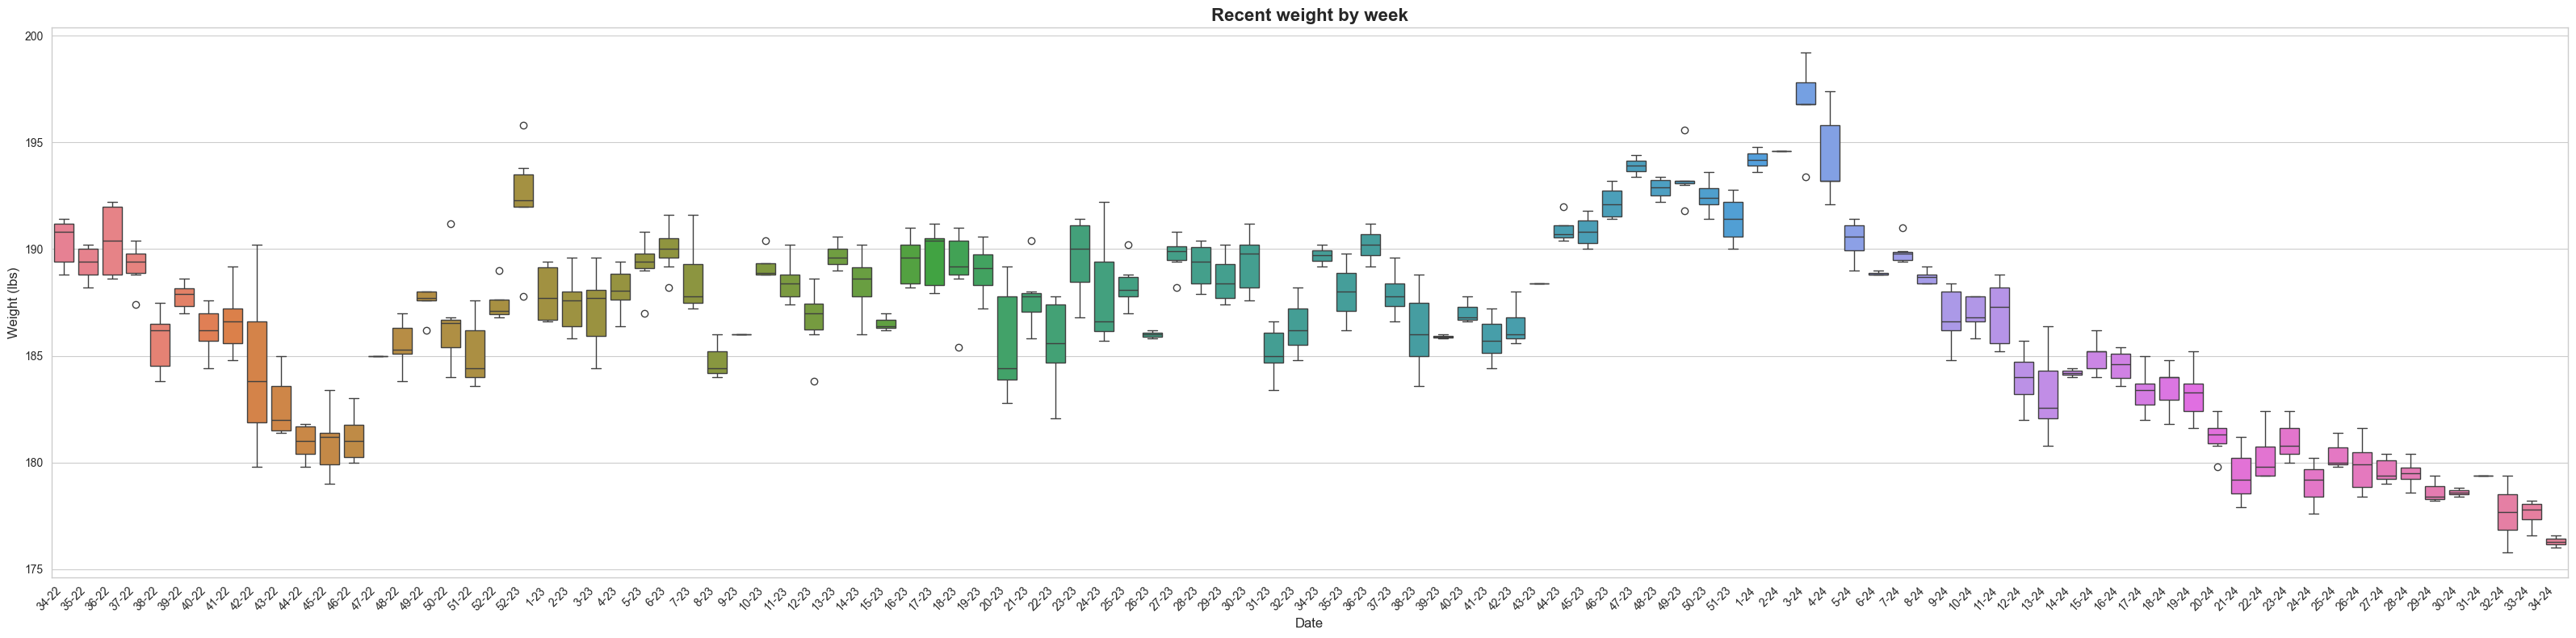

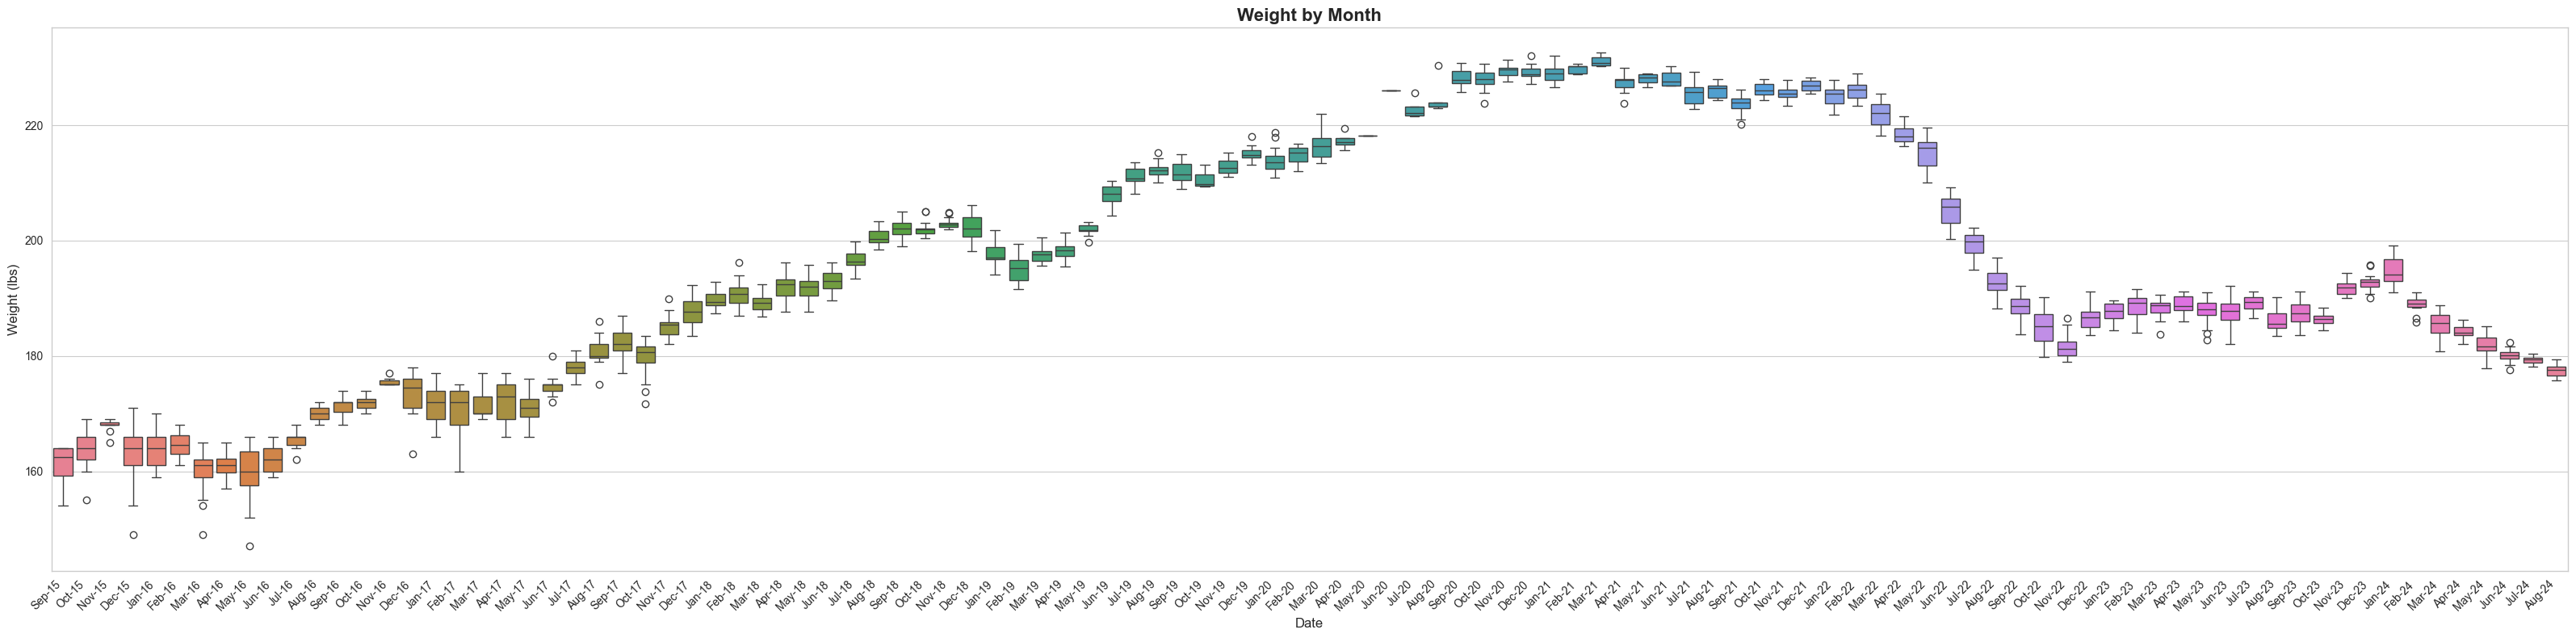

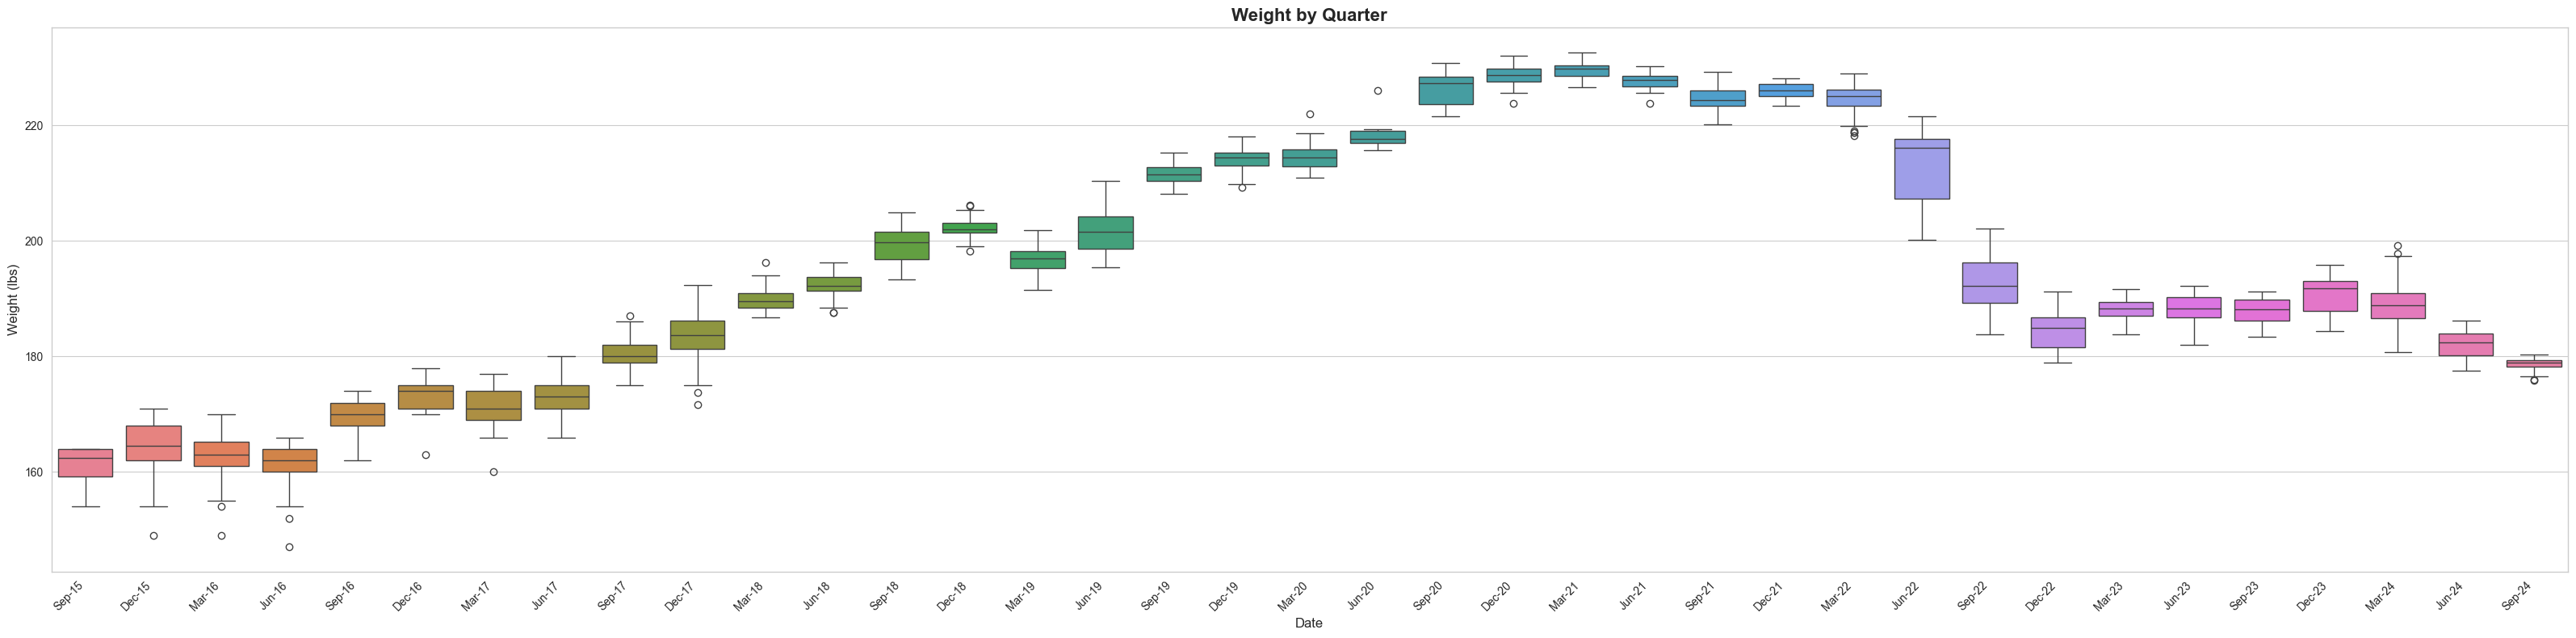

In [34]:
earliest = df.iloc[-1].Date - pd.DateOffset(years=2)
display(earliest)
box_plot_weight = box_plot_weight_mpl
# vegas box plot doesnt' sort by date - it sorts by string - yuk!
box_plot_weight(df[earliest:], idx_month_year, title="Recent weight by month")
box_plot_weight(df[earliest:], idx_week_year, title="Recent weight by week")
box_plot_weight(df_alltime, idx_month_year, "Weight by Month")
box_plot_weight(df_alltime, idx_quarter_year, "Weight by Quarter")

# Time Series Analysis using resampling

In [27]:
print("Scroll to see year markers, select in index to zoom in")
metric = idx_weight


def make_domain(df):
    y_min = min(df[idx_weight])
    y_max = max(df[idx_weight])
    distance = y_max - y_min
    buffer = 0.05 * distance
    buffer = min(buffer, 5)  # no point being more then 5 lbs
    domain = (y_min - buffer, y_max + buffer)
    return domain


def graph_weight_as_line(df, freq, domain):
    domain = make_domain(df)
    pd_freq_value = freq[0]  # hack, pandas Freq are D,W,M
    df_group_time = df.copy()[metric].resample(pd_freq_value)
    t1 = df_group_time.count().reset_index()
    # Create the root df for output
    df_to_graph = t1.drop(columns=metric)
    for q in [0.25, 0.5, 0.9]:
        # for q in [0.25, 0.9]:
        df_to_graph[f"p{q * 100}"] = df_group_time.quantile(q).reset_index()[metric]

    # Now start adding back the rows
    df_melted = df_to_graph.melt(id_vars=[idx_date])

    height_in_inches = 60  # todo figure out how to get this by calculation

    selection = alt.selection_point(
        fields=["variable"], bind="legend"
    )  # Updated to Altair 5's selection_point

    c = (
        alt.Chart(df_melted)
        .mark_line(point=True)
        .encode(
            y=alt.Y("value", title="", scale=alt.Scale(domain=domain)),
            x=alt.X(f"{idx_date}:T"),
            color=alt.Color("variable"),
            tooltip=[alt.Tooltip(f"{idx_date}:T"), alt.Tooltip("value:Q")],
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
        )
        .properties(
            width=16 * height_in_inches,
            height=6 * height_in_inches,
            title=f"{metric} By {freq}",
        )
        .interactive()
    ).add_params(selection)  # Updated to Altair 5's add_params
    display(c)

    return c


earliest = df.iloc[-1].Date - pd.DateOffset(years=1)
graph_weight_as_line(df[earliest:], "Week", (180, 205))
for freq in "Month Week".split():
    graph_weight_as_line(df, freq, (150, 240))

Scroll to see year markers, select in index to zoom in


alt.Chart(...)

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_83561/299708636.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_group_time = df.copy()[metric].resample(pd_freq_value)


alt.Chart(...)

alt.Chart(...)

In [28]:
dfM = dfW.resample("W").median()

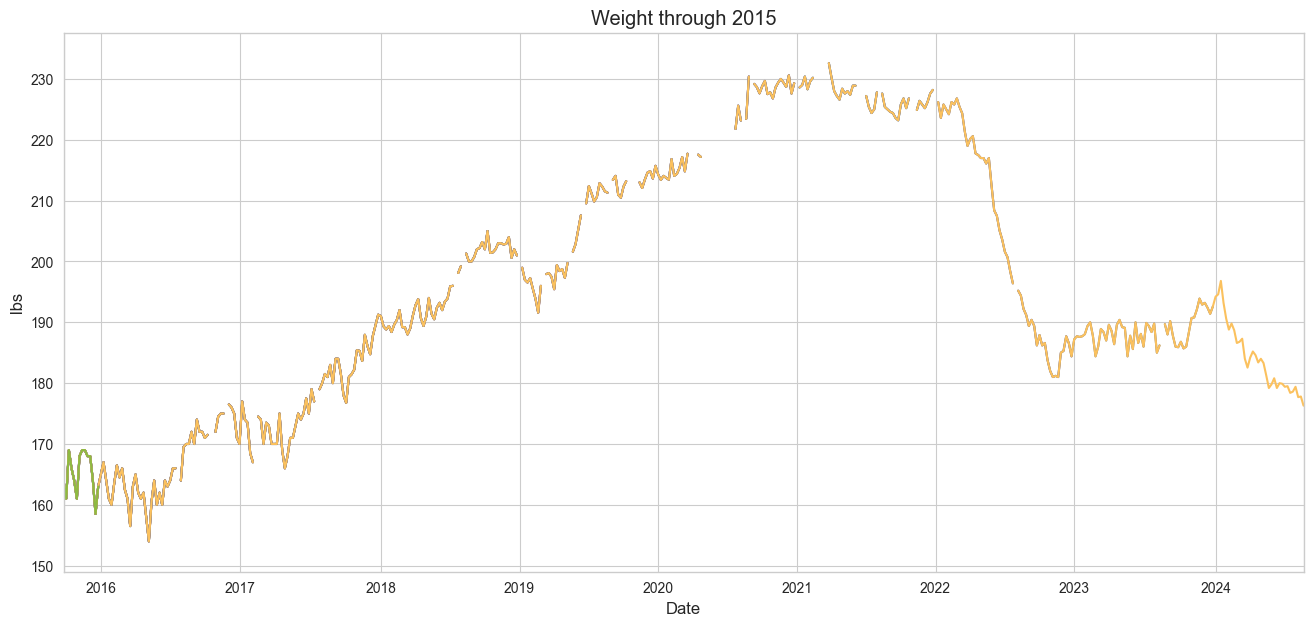

In [29]:
import datetime

anim_year_base = 2015
years_to_plot = datetime.datetime.now().year - anim_year_base + 1
anim_fig_size = (16, 7)
fig = plt.figure(figsize=anim_fig_size)
ax = fig.add_subplot(1, 1, 1)

dfRelevant = dfM[f"{anim_year_base}" : f"{anim_year_base + years_to_plot}"]
min_weight = dfRelevant.min() - 5
max_weight = dfRelevant.max() + 5
# TODO Generate the axis limits programatically


dfM[f"{anim_year_base}" : f"{anim_year_base}"].plot(
    title="Title Over Written",
    figsize=anim_fig_size,
    ylim=(min_weight, max_weight),
    ax=ax,
)
ax.set_ylabel("lbs")
ax.set_xlabel("")


def animate(i):
    year = f"{anim_year_base + i}"
    return dfM[f"{anim_year_base}" : year].plot(title=f"Weight through {year}").lines


anim = animation.FuncAnimation(
    fig,
    animate,
    frames=years_to_plot,
    interval=timedelta(seconds=2).seconds * 1000,
    blit=False,
)
HTML(anim.to_html5_video())
# TODO - how to get rid of the initial plot from animate.init() -- no clue.

In [30]:
dfM.min()

np.float64(154.0)

In [31]:
from pandasai import PandasAI
from pandasai.llm.openai import OpenAI

ModuleNotFoundError: No module named 'pandasai'

In [ ]:
def setup_gpt():
    import os
    import json

    PASSWORD = "replaced_from_secret_box"
    with open(os.path.expanduser("~/gits/igor2/secretBox.json")) as json_data:
        SECRETS = json.load(json_data)
        PASSWORD = SECRETS["openai"]
    return PASSWORD


# model = "gpt-4"
model = "gpt-3.5-turbo"
llm = OpenAI(setup_gpt(), model=model)
pandas_ai = PandasAI(llm, verbose=True)
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)
pandas_ai.run(df, "Remove rows with weights less then 100 from", show_code=True)
# df = df[df[idx_weight] > 100]

pandas_ai.run(df, prompt="What is the average weight?", show_code=False)

In [ ]:
prompt = """
Graph  P5, P50 and P90 Weight over time, let the x axis be every quarter 
"""
# pandas_ai.run(df, prompt=prompt, show_code=True)